In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kamrannaseer","key":"86bfee909777b6a9a32c48d76ca589d5"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d arpitjain007/game-of-deep-learning-ship-datasets

 90% 73.0M/80.9M [00:01<00:00, 34.3MB/s]
100% 80.9M/80.9M [00:01<00:00, 64.4MB/s]


In [7]:
!mkdir arpitjain007

In [8]:
! unzip game-of-deep-learning-ship-datasets.zip -d arpitjain007

Streaming output truncated to the last 5000 lines.
  inflating: arpitjain007/train/images/2829342.jpg  
  inflating: arpitjain007/train/images/2829344.jpg  
  inflating: arpitjain007/train/images/2829347.jpg  
  inflating: arpitjain007/train/images/2829351.jpg  
  inflating: arpitjain007/train/images/2829357.jpg  
  inflating: arpitjain007/train/images/2829359.jpg  
  inflating: arpitjain007/train/images/2829362.jpg  
  inflating: arpitjain007/train/images/2829366.jpg  
  inflating: arpitjain007/train/images/2829369.jpg  
  inflating: arpitjain007/train/images/2829372.jpg  
  inflating: arpitjain007/train/images/2829373.jpg  
  inflating: arpitjain007/train/images/2829377.jpg  
  inflating: arpitjain007/train/images/2829378.jpg  
  inflating: arpitjain007/train/images/2829381.jpg  
  inflating: arpitjain007/train/images/2829382.jpg  
  inflating: arpitjain007/train/images/2829383.jpg  
  inflating: arpitjain007/train/images/2829385.jpg  
  inflating: arpitjain007/train/images/2829386.j

In [9]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import Image


### Importing the Dataset

In [10]:
data_csv = pd.read_csv('/content/arpitjain007/train/train.csv')
print('Data shape: ', data_csv.shape)

categories = {0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}

# I want classes to start from 0. So I subtracted 1 from the categories
data_csv['category'] = data_csv['category'] - 1
data_csv['label'] = data_csv['category'].map(categories)
data_csv['label']  = pd.Categorical(data_csv['label'])
data_csv.head(5)

Data shape:  (6252, 2)


,image,category,label
0,2823080.jpg,0,Cargo
1,2870024.jpg,0,Cargo
2,2662125.jpg,1,Military
3,2900420.jpg,2,Carrier
4,2804883.jpg,1,Military


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


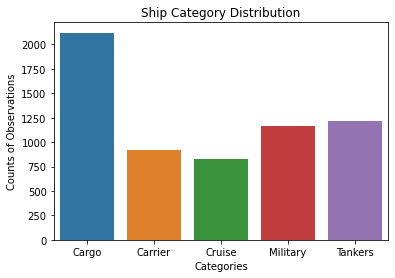

In [11]:
sns.countplot(data_csv['label'])
plt.title('Ship Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations');

In [12]:
# Importing the images.

import cv2

path = '/content/arpitjain007/train/images/'

# List of image names
img_list = list(data_csv['image'])

data_img = []

for each in img_list:
    # Each image path
    each_path = os.path.join(path, each)
    # Read each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. Convert it to RGB
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resize the images
    each_img_resized = cv2.resize(each_img, (128,128))
    # Save arrays to a list
    data_img.append(each_img_resized)

# Converting list to numpy array
X = np.array(data_img)
print('Shape of X: ', X.shape)

Shape of X:  (6252, 128, 128, 3)


In [13]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(data_csv['category'].values.reshape(-1,1))
print('Shape of y: ', y.shape)

Shape of y:  (6252, 5)


### Train, Validation and Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (4251, 128, 128, 3)
y_train shape:  (4251, 5)
X_val shape  :  (1063, 128, 128, 3)
y_val shape  :  (1063, 5)
X_test shape :  (938, 128, 128, 3)
y_test shape :  (938, 5)


### Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

train_gen.fit(X_train)
validation_gen.fit(X_val)

### Building Model with Xception

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 100
epochs = 15

In [17]:
# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(5, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

# Fitting the model with train and validation augmented datasets.
history = model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size)

83689472/83683744 [==============================] - 0s 0us/step
Epoch 1/15
42/42 [==============================] - 43s 736ms/step - loss: 1.4706 - accuracy: 0.3708 - val_loss: 1.7155 - val_accuracy: 0.4092
Epoch 2/15
42/42 [==============================] - 29s 692ms/step - loss: 0.8830 - accuracy: 0.6596 - val_loss: 1.0195 - val_accuracy: 0.6510
Epoch 3/15
42/42 [==============================] - 29s 677ms/step - loss: 0.6468 - accuracy: 0.7496 - val_loss: 0.7240 - val_accuracy: 0.7516
Epoch 4/15
42/42 [==============================] - 29s 680ms/step - loss: 0.5240 - accuracy: 0.8001 - val_loss: 0.7119 - val_accuracy: 0.7563
Epoch 5/15
42/42 [==============================] - 29s 683ms/step - loss: 0.4810 - accuracy: 0.8158 - val_loss: 0.5636 - val_accuracy: 0.7921
Epoch 6/15
42/42 [==============================] - 29s 686ms/step - loss: 0.4142 - accuracy: 0.8443 - val_loss: 0.5482 - val_accuracy: 0.8006
Epoch 7/15
42/42 [==============================] - 29s 684ms/step - loss: 0.

### Predicting Test Dataset

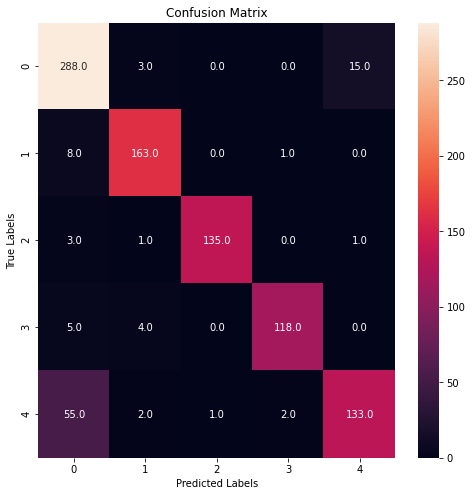

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [19]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       306
           1       0.94      0.95      0.94       172
           2       0.99      0.96      0.98       140
           3       0.98      0.93      0.95       127
           4       0.89      0.69      0.78       193

    accuracy                           0.89       938
   macro avg       0.92      0.89      0.90       938
weighted avg       0.90      0.89      0.89       938



### Trying the Model with Some Images

In [21]:
test_img = pd.read_csv('/content/arpitjain007/test_ApKoW4T.csv')
sample_img = test_img.sample(5)

# List of image names
img_list = list(sample_img['image'])

sample_img_data = []

for each in img_list:
    # Each images' path
    each_path = os.path.join(path, each)
    # Read each image
    each_img = cv2.imread(each_path)
    # OpenCv default color is BGR. Convert it to RGB
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
    # Resize the images
    each_img_resized = cv2.resize(each_img, (128,128))
    # Save arrays to a list
    sample_img_data.append(each_img_resized)

# Converting list to numpy array
sample_img_data = np.array(sample_img_data)
print('Shape of X: ', sample_img_data.shape)

Shape of X:  (5, 128, 128, 3)


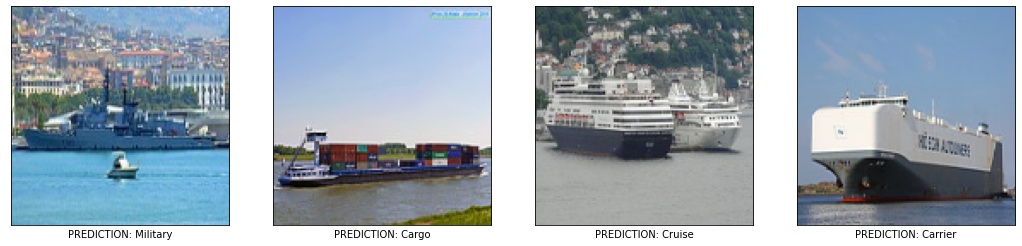

In [22]:
# Predicting random 5 images
sample_pred = model.predict(sample_img_data)
sample_classes = np.argmax(sample_pred, axis = 1)

# Visualizing the predictions
i = 0
plt.figure(figsize=(18,9))
for each in range(4):
    i += 1
    plt.subplot(2,4,i)
    plt.imshow(sample_img_data[each])
    plt.xlabel('PREDICTION: ' + str(categories[sample_classes[each]]))
    plt.xticks([])
    plt.yticks([])

In [23]:
model.save("MultiClass_Ship_Classification_XCeption.h5")